In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

The latent variable $X$ has a Bernoulli distribution

$$X\sim Bernoulli(p),$$

and the observables are conditionally independent:

$$\left\{
\begin{split}
&f(y_i|X=1)=\alpha_iy_i^{\alpha_i-1},\\
&f(y_i|X=0)=\alpha_i(1-y_i)^{\alpha_i-1},
\end{split}\right.
$$

where $\alpha_i$'s are i.i.d. variables coming from a Pareto or exponential distribution. And the corresponding distribution functions would be

$$\left\{
\begin{split}
&F(y_i|X=1)=y_i^{\alpha_i},\\
&F(y_i|X=0)=1-(1-y_i)^{\alpha_i}.
\end{split}\right.
$$

In [7]:
def gen_alpha(k, shape):
    alphas = np.random.pareto(k-1, size=shape)
    return(alphas+1)

flip = lambda y,x: x*y+(1-x)*(1-y)

def cond_gen(x, alphas):
    if type(alphas) == np.ndarray:
        shape = alphas.shape
    else:
        shape = 1
    Z = np.random.uniform(size=shape)**(1/alphas)
    Y = flip(Z, x)
    return(Y)

cond_ltail = lambda y,alpha,x: flip(flip(y,x)**alpha, x)
ltail = lambda y,alpha,p: p*cond_ltail(y,alpha,1)+(1-p)*cond_ltail(y,alpha,0)
preftail = lambda y,alpha,p,pref,**kwds: flip(ltail(y,alpha,p), 1-pref)
#preftail = lambda y,alpha,p,pref,**kwds: ltail(y,alpha,p) if pref==0 else (1-ltail(y,alpha,p))
easytail = lambda row,p:preftail(p=p, **dict(row))

cond_den = lambda y,alpha,x,**kwds: alpha*flip(y,x)**(alpha-1)
easyden = lambda row,x:cond_den(x=x, **dict(row))

In [8]:
class RV:
    
    def __init__(self, alphas, p=0.5):
        self.alphas = np.sort(alphas)
        self.p = p
        return
    
    def gen_obs(self):
        X = np.random.binomial(1, self.p)
        Y = cond_gen(X, self.alphas)
        self.X, self.Y = X,Y
        return
    
    def zipout(self):
        return(list(zip(self.Y, self.alphas)))
    
    def out(self):
        return(self.p, self.X, self.zipout())

In [41]:
help(np.sort)

Help on function sort in module numpy.core.fromnumeric:

sort(a, axis=-1, kind='quicksort', order=None)
    Return a sorted copy of an array.
    
    Parameters
    ----------
    a : array_like
        Array to be sorted.
    axis : int or None, optional
        Axis along which to sort. If None, the array is flattened before
        sorting. The default is -1, which sorts along the last axis.
    kind : {'quicksort', 'mergesort', 'heapsort', 'stable'}, optional
        Sorting algorithm. Default is 'quicksort'.
    order : str or list of str, optional
        When `a` is an array with fields defined, this argument specifies
        which fields to compare first, second, etc.  A single field can
        be specified as a string, and not all fields need be specified,
        but unspecified fields will still be used, in the order in which
        they come up in the dtype, to break ties.
    
    Returns
    -------
    sorted_array : ndarray
        Array of the same type and shape a

In [9]:
class neo_tuple:
    def __init__(self, *value):
        self.val = value
        return
    def __repr__(self):
        return(repr(self.val))
    def __add__(self, value):
        output = neo_tuple(*(self.val+value.val))
        return output
    def astuple(self):
        return(self.val)

def grid1d(rang, n):
    gap = (rang[1]-rang[0])/n
    output = gap/2 + np.linspace(*rang, n, False)
    output = [neo_tuple(x) for x in output]
    return(output)

def gridnd(rang, shape):
    r,n = rang[0],shape[0]
    if len(shape)==1:
        return(np.array(grid1d(r,n)))
    subgrid = gridnd(rang[1:], shape[1:])
    values = grid1d(r,n)
    output = [np.full(subgrid.shape, x)+subgrid for x in values]
    return(np.array(output))

In [10]:
class dist:
    
    def __init__(self, buffer, rang=((0,1),)):
        self.buffer = np.array(buffer)
        self.range = rang
        self.area = np.prod([n[1]-n[0] for n in rang])
        return
    
    def __repr__(self):
        return(repr(self.buffer))
    
    def __mul__(self, value):
        return(dist(self.buffer*value, self.range))
    
    def grid(self):
        shape = self.buffer.shape
        return(gridnd(self.range, shape))
    
    def integrate(self):
        return(self.buffer.mean()*self.area)
    
    def normalize(self):
        self.buffer = self.buffer/self.integrate()
        return
    
    def bayes(self, probs):
        prods = self.buffer*probs
        output = dist(prods, self.range)
        output.normalize()
        return(output)

In [11]:
class supervisor:

    std_prior = dist([1]*100)
    std_grid = std_prior.grid()
      
    def __init__(self, env, suspicion, prior = std_prior):
        self.env = env
        self.prior = prior
        self.grid = [x.val[0] for x in prior.grid()]
        self.suspicion = suspicion
    
    def get_bias(self):
        # Calculate current bias from prior
        self.bias = (self.prior*self.grid).integrate()
        
    def get_ck(self):
        # Access common knowledge
        self.knowledge = self.env.ck.copy()
        return
    
    def analysis(self):
        # Analyses and actions conducted in a step
        self.get_ck()
        self.knowledge['y'] = pd.Series(self.reports)
        n = len(self.reports)
        sample1 = np.random.choice(n,int(n/2),False) # terminals to test
        sample2 = np.array(set(range(size)).difference(sample1)) # terminals to trust
        self.q = self.demi_decision(sample2)
        suspects = self.suspecting(sample1)
        self.env.suspects = suspects
        self.correcting(suspects)
        self.env.decision = self.decide()
        self.update()
        return
    
    def demi_decision(self, sample):
        # Derive a (temporary) posterior distribution of X with trusted reports
        p = self.bias
        df = self.knowledge.loc[sample, ['y','alpha']]
        prob1 = df.apply(easyden, axis=1, x=1).prod()*p
        prob0 = df.apply(easyden, axis=1, x=0).prod()*(1-p)
        q = prob1/(prob1+prob0)
        return(q)
    
    def update(self):
        # Update the prior
        temp = self.knowledge
        cond = lambda p: temp.apply(easyden, axis=1, x=1).prod()*p\
        +temp.apply(easyden, axis=1, x=0).prod()*(1-p)
        conds = [cond(p) for p in std_grid]
        self.prior = self.prior.bayes(conds)
        self.get_bias()
        return
    
    def suspecting(self, sample):
        # Return the suspected agents
        temp = self.knowledge.loc[sample]
        suspects = temp.apply(easytail, axis=1, p=self.q)<self.suspicion
        suspects = temp.index.values[suspects]
        return(suspects)
    
    def correcting(self, suspects):
        # Access the true values of the suspicious reports
        for i in suspects:
            self.knowledge.loc[i,'y']=self.env.rv.Y[i]
        return
    
    def decide(self):
        # Make a decision with reports corrected
        p = self.bias
        df = self.knowledge[['y','alpha']]
        prob1 = df.apply(easyden, axis=1, x=1).prod()*p
        prob0 = df.apply(easyden, axis=1, x=0).prod()*(1-p)
        if prob1>=prob0:
            decision = 1
        else:
            decision = 0
        self.env.rec.append(decision)
        return(decision)

In [24]:
class terminal:
    
    std_grid = dist([1]*100).grid()
        
    def __init__(self,env,pid,pref,soc=1,sus_hat=0.05):
        self.pid = pid
        self.soc = soc
        self.pref = pref
        self.sus_hat = sus_hat
        self.env = env
        return
    
    def update_status(self):
        self.status = self.env.ck.loc[self.pid].copy()
        return
    
    def observe(self):
        # Access own observation
        pos = self.status['pos']
        self.obs = self.env.rv.zipout()[pos]
        return
    
    def get_info(self):
        # Learn info from others
        av_pid = list[self.env.network.neighbors(self.pid)] # id of accessible agents
        av_pos = self.env.ck.loc[av_pid, 'pos']
        self.info = [self.env.rv.zipout()[p] for p in av_pos]
        self.info = self.info + [self.obs]
        return
    
    def update_prior(self):
        cond = lambda p: np.prod([cond_den(*pair,1) for pair in self.info])*p\
        +np.prod([cond_den(*pair,0) for pair in self.info])*(1-p)
        conds = [cond(p) for p in std_grid]
        self.prior = self.prior.bayes(conds)
        return
    
    def report(self):
        p = (self.prior*std_grid).integrate()
        tail = lambda y: preftail(y, self.status['alpha'], p, self.pref)
        tails = np.vectorize(tail)(std_grid)
        safe = std_grid[tails>sus_hat]
        lwb, upb = min(safe), max(safe)
        val = (max(upb, self.obs) if self.pref==1 else min(self.obs, lwb))
        self.val = val
        self.env.boss.reports.update({self.pid:val})
        return
    
    def ready_to_update_sus(self):
        guilty = self.env.guilty
        av_pid = list[self.env.network.neighbors(self.pid)]
        gnbor = set(guilty).intersection(set(av_pid+[self.pid]))
        gnbor = list(gnbor)
        self.temp = max([self.env.agentls[i].sus_hat for i in gnbor])
        return
    
    def update_sus(self):
        self.sus_hat = self.temp
        return

In [21]:
class net(nx.Graph):
    
    def initialize(self,size,q,t,k,env):
        self.q, self.t, self.k, self.env = q,t,k,env
        self.add_nodes_from(range(size))
        return
    
    def is_edge(self,i,j):
        ls = list(self.edges)
        case1 = (i,j) in ls
        case2 = (j,i) in ls
        return(bool(case1+case2))
    
    def soc_prod(self, i, j):
        soci = self.env.agentls[i].soc
        socj = self.env.agentls[j].soc
        return(soci*socj)
    
    def diff(self, i, j):
        state1 = self.env.ck.loc(i,['pref','pos'])
        state2 = self.env.ck.loc(j,['pref','pos'])
        locate = lambda x: x['pos'] if x['pref']==1 else -x['pos']
        return(np.abs(locate(state1)-locate(state2)))
    
    def shift(self,i,j): 
        cc = self.soc_prod(i,j)
        d = self.diff(i,j)
        p_break = q
        p_connect = q*(cc**t)*np.exp(-k*d)
        if self.is_edge(i,j):
            if np.random.uniform()<p_break:
                self.remove_edge(i,j)
        else:
            if np.random.uniform()<p_connect:
                self.add_edge(i,j)
        return
    
    def timestep(self):
        for i in list(nt.nodes):
            for j in list(nt.nodes):
                if j > i:
                    self.shift(i,j)
        return

In [22]:
class env:
    
    def __init__(self,alphas,q,t,l):
        self.rv = RV(alphas)
        self.size = len(list(alphas))
        self.G = net()
        self.G.initialize(self.size,q,t,l,env=self)
        self.agentls = []
        for i in range(self.size):
            self.agentls.append(terminal(i, pref, soc, sus_hat, env=self))
            self.G.add_node(i)
        self.ck = pd.DataFrame({'pref':[a.pref for a in agentls]})
        poses = list(range(self.size))
        np.random.shuffle(poses)
        self.ck['pos'] = poses
        self.ck['alpha'] = [alphas[i] for i in poses]
        env.boss = supervisor(prior, suspicion, env=env)
    
    def find_guilty(self):
        self.suspects = np.sort(self.suspects)
        y = [self.rv.Y[i] for i in self.suspects]
        val = [self.agentls[i].val for i in self.suspects]
        self.guilty = [self.suspects[i] for i in range(len(y)) if y[i]!=val[i]]     
        
    def ckswap(self, i, j):
        temp = self.ck.loc[i,['alpha','pos']]
        self.ck.loc[i,['alpha','pos']]=self.ck.loc[j,['alpha','pos']]
        self.ck.loc[j,['alpha','pos']]=temp
        return
            
    def penalty(self):
        innocent = list(set(range(self.size)).difference(self.guilty))
        pairs = list(zip(self.guilty, innocent))
        [self.ckswap(*pair) for pair in pairs]
        return
    
    def timestep(self):
        self.rv.gen_obs()
        [a.obs() for a in self.agentls]
        []

In [772]:
poses = list(range(10))
np.random.shuffle(poses)

In [774]:
alphas = [1,4,9,16,25,36,49,64,81,100]

In [776]:
[alphas[i] for i in poses]

[1, 25, 49, 16, 4, 64, 100, 81, 9, 36]

In [773]:
poses

[0, 4, 6, 3, 1, 7, 9, 8, 2, 5]

In [ ]:
class model:
    
    def initialize(self, alphas):
        self.size = len(list(alphas))
        

In [751]:
df2.index.values[[True,False]]

array([0], dtype=int64)

In [758]:
pd.Series([1,2,3], index=[30,'h','x']).index.values

array([30, 'h', 'x'], dtype=object)

In [744]:
df2

,a,b
0,2,3
1,4,5


In [745]:
df2.apply(sum,axis=1).prod()

45

In [737]:
np.array([1,2])*[3,4]

array([3, 8])

In [731]:
np.array(set([1,2,3]))

array({1, 2, 3}, dtype=object)

In [732]:
set([1,2,3]).difference(np.array([3,4,5]))

{1, 2}

In [658]:
df1 = pd.DataFrame({'a':[1,3]})
print(df1)
df2 = df1.copy(deep=False)
print(df2)
df2['b']=pd.Series({1:5,0:3})
df3 = df2.loc[0]
print(df3)
df2['a']=[2,4]

print(df1)
print(df2)
print(df3)
sum0 = lambda array,p:sum(array)*p
print(df2.apply(sum0, p=2, axis=1))
type(df2.apply(sum0, p=2, axis=0))

   a
0  1
1  3
   a
0  1
1  3
a    1
b    3
Name: 0, dtype: int64
   a
0  1
1  3
   a  b
0  2  3
1  4  5
a    2
b    3
Name: 0, dtype: int64
0    10
1    18
dtype: int64


pandas.core.series.Series

In [651]:
df3 = df2.loc[0]
df3['a']=4
print(df3)
print(df2)
print(df1)

a    4
b    3
Name: 0, dtype: int64
   a  b
0  4  3
1  4  5
   a
0  2
1  4


In [652]:
df2['a']=[100,101]
print(df3)
print(df2)
print(df1)

a    100
b      3
Name: 0, dtype: int64
     a  b
0  100  3
1  101  5
   a
0  2
1  4


In [710]:
list(nt.nodes)

[0, 1, 2, 3, 4]

In [699]:
nt = nx.Graph()
nt.add_nodes_from(range(5))
nt.add_edge(0,3)
list(nt.edges())

[(0, 3)]

In [698]:
help(nx.edges)

Help on function edges in module networkx.classes.function:

edges(G, nbunch=None)
    Return an edge view of edges incident to nodes in nbunch.
    
    Return all edges if nbunch is unspecified or nbunch=None.
    
    For digraphs, edges=out_edges



In [687]:
help(nx.Graph.add_nodes_from)

Help on function add_nodes_from in module networkx.classes.graph:

add_nodes_from(self, nodes_for_adding, **attr)
    Add multiple nodes.
    
    Parameters
    ----------
    nodes_for_adding : iterable container
        A container of nodes (list, dict, set, etc.).
        OR
        A container of (node, attribute dict) tuples.
        Node attributes are updated using the attribute dict.
    attr : keyword arguments, optional (default= no attributes)
        Update attributes for all nodes in nodes.
        Node attributes specified in nodes as a tuple take
        precedence over attributes specified via keyword arguments.
    
    See Also
    --------
    add_node
    
    Examples
    --------
    >>> G = nx.Graph()  # or DiGraph, MultiGraph, MultiDiGraph, etc
    >>> G.add_nodes_from('Hello')
    >>> K3 = nx.Graph([(0, 1), (1, 2), (2, 0)])
    >>> G.add_nodes_from(K3)
    >>> sorted(G.nodes(), key=str)
    [0, 1, 2, 'H', 'e', 'l', 'o']
    
    Use keywords to update specific

In [645]:
df2.loc[[0,1],'a']

0    2
1    4
Name: a, dtype: int64

In [590]:
def test2(a,b):
    return(a,b)

fill = {'a':2,'b':3}

test2(**dict(a=2,b=3))

(2, 3)

In [563]:
tuple_sum = lambda x, y: tuple([sum(pair) for pair in zip(x,y)])
tuple_sum((2,3),(4,5))

(6, 8)

In [667]:
np.vectorize(lambda x:x**2)(np.array([[1,2],[3,4]]))

array([[ 1,  4],
       [ 9, 16]])

In [703]:
np.random.uniform()

0.24435061549363357

In [553]:
rv = RV(np.array([3,5]))

In [554]:
rv.gen_obs()

In [555]:
rv.out()

(0.5, 0, [(3, 0.3572282308740402), (5, 0.299045056305428)])

In [103]:
class RV:
    
    '''Random variables (A latent binary and several observables)'''
    
    def gen_obs1(self, num, p=0.5):
        X = np.random.binomial(1, p)
        Y = np.sqrt(np.random.uniform(size=num))
        if(X==0): Y = 1-Y
        self.type = "Conditionally i.i.d."
        self.p, self.X, self.Y = p, X, Y
        return
    
    def gen_obs(self, case, *args):
        if(case == "Conditionally i.i.d."):
            self.gen_obs1(*args)
            
    def den(self):
        if(self.type == "Conditionally i.i.d."):
            return(self.den1())
    
    def den1(self):
        Y = 2*self.Y
        if(self.X==0):
            Y = 2-Y
            return(Y.cumprod()[-1]*(1-self.p))
        return(Y.cumprod()[-1]*self.p)
    
    def tailprod(self):
        if(self.type == "Conditionally i.i.d."):
            return(self.tailprod1())
    
    def tailprod1(self):
        Y = self.Y
        p = self.p
        if(self.X==0):
            Y,p = 1-Y,1-p
        tails = np.array(map(lambda y:min(y**2,1-y**2), Y))
        return(tails.cumprod()[-1]*p)
        
    def __repr__(self):
        return(''.join([str(self.Y),'\n with latent binary: ',str(self.X)]))

In [506]:
test = gen_alpha(3,10000)
max(test)

135.43489834988364

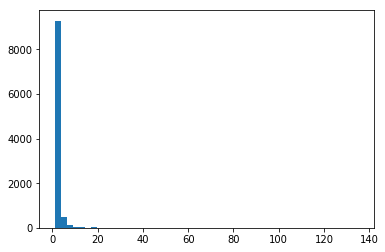

In [514]:
%matplotlib inline
(n, bins, patches)=plt.hist(test,50)

In [515]:
sum(test>30)

16

In [517]:
np.sort(test)[-16:]

array([ 36.28364753,  37.44554778,  37.59514696,  42.5067744 ,
        47.29418705,  49.631585  ,  50.03953163,  50.86735506,
        51.71346124,  54.11515818,  56.51187749,  58.80494291,
        62.82132378, 116.69416438, 116.96577901, 135.43489835])

In [511]:
n

array([9.942e+03, 4.000e+01, 5.000e+00, 7.000e+00, 3.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00])

In [424]:
np.sort(test)

array([ 1.00847954,  1.01625118,  1.01633262,  1.01886804,  1.02140753,
        1.02377871,  1.02380769,  1.03595151,  1.04226374,  1.05766002,
        1.05963472,  1.06231985,  1.07285821,  1.07432421,  1.08234524,
        1.11565023,  1.11977056,  1.13667165,  1.17064596,  1.17651643,
        1.18709366,  1.19132295,  1.19170966,  1.20710208,  1.21270109,
        1.22337752,  1.23911024,  1.27377432,  1.27481591,  1.28380425,
        1.31128766,  1.31289882,  1.33173846,  1.33865376,  1.35560126,
        1.35707954,  1.38089409,  1.39849444,  1.41095079,  1.41277915,
        1.45043878,  1.46140376,  1.59696161,  1.63115017,  1.66444926,
        1.66521441,  1.69187562,  1.72562722,  1.74629264,  1.75535739,
        1.76949581,  1.81911228,  1.82165597,  1.8881392 ,  1.97641781,
        2.05631032,  2.12119245,  2.21608133,  2.27352368,  2.29255755,
        2.43219277,  2.50983583,  2.51887278,  2.5387529 ,  2.57362993,
        2.73712184,  2.75352864,  2.76175297,  2.92714231,  3.13

In [360]:
dist([1]*50).grid()

array([(0.01,), (0.03,), (0.05,), (0.06999999999999999,), (0.09,),
       (0.11,), (0.13,), (0.15000000000000002,), (0.17,), (0.19,),
       (0.21000000000000002,), (0.23,), (0.25,), (0.27,),
       (0.29000000000000004,), (0.31,), (0.33,), (0.35000000000000003,),
       (0.37,), (0.39,), (0.41000000000000003,), (0.43,), (0.45,),
       (0.47000000000000003,), (0.49,), (0.51,), (0.53,), (0.55,),
       (0.5700000000000001,), (0.59,), (0.61,), (0.63,), (0.65,), (0.67,),
       (0.6900000000000001,), (0.7100000000000001,), (0.73,), (0.75,),
       (0.77,), (0.79,), (0.81,), (0.8300000000000001,), (0.85,), (0.87,),
       (0.89,), (0.91,), (0.93,), (0.9500000000000001,), (0.97,), (0.99,)],
      dtype=object)

In [211]:
np.array([[1,2,3],[4,5,6]])

array([[1, 2, 3],
       [4, 5, 6]])

In [206]:
np.ndarray(5, dtype=tuple)

array([None, None, None, None, None], dtype=object)

In [189]:
a = ((0,1),(0,2),(0,3))
b = (10,5,2)

In [196]:
np.meshgrid(*tuple([grid1d(a[i], b[i]) for i in range(3)]))[0].shape

(5, 10, 2)

In [170]:
np.linspace(0,1,50,False)

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98])

In [151]:
dist(temp.Y).bayes(temp.Y)

array([7.42848143e-01, 3.24093159e-02, 7.06681293e-04, 1.70756131e+00,
       1.77910128e+00, 1.90269823e-01, 3.74453188e+00, 6.71590603e-02,
       8.62830577e-01, 8.72581929e-01])

In [135]:
temp2 = dist(shape=temp.Y.shape, buffer=temp.Y).normalize()

In [137]:
temp2*temp2

dist([1.10409809e+00, 4.81700924e-02, 1.05034316e-03, 2.53795503e+00,
      2.64428516e+00, 2.82798780e-01, 5.56551233e+00, 9.98187730e-02,
      1.28242845e+00, 1.29692192e+00])

In [376]:
temp.Y

array([0.38467042, 0.08034775, 0.01186453, 0.58321263, 0.59530442,
       0.19468107, 0.86364952, 0.1156621 , 0.4145735 , 0.41690958])

In [92]:
temp.Y.cumprod()

array([3.84670420e-01, 3.09074015e-02, 3.66701818e-04, 2.13865133e-04,
       1.27314859e-04, 2.47857932e-05, 2.14062384e-05, 2.47589051e-06,
       1.02643858e-06, 4.27932083e-07])

In [54]:
agentlist = {}

def agents_by_id(iterable,ls):
    return([ls[i] for i in iterable])

In [375]:
def den(p, X, Y, case="Conditionally i.i.d."):
    rv = RV()
    rv.X, rv.Y, rv.p, rv.case = X,Y,p,case
    return(rv.den())

def tailprod(p, X, Y, case="Conditionally i.i.d."):
    rv = RV()
    rv.X, rv.Y, rv.p, rv.case = X,Y,p,case
    return(rv.tailprod())

In [ ]:
class cross_section:

In [377]:
def test():
    return(2,3)

test()

(2, 3)

In [ ]:
def repeat

In [342]:
neo_tuple(1)+neo_tuple(2,3)

(1, 2, 3)

In [345]:
np.full((2,3,4),neo_tuple(1),dtype=object)#+np.full((2,3,4),neo_tuple(2),dtype=object)

array([[[(1,), (1,), (1,), (1,)],
        [(1,), (1,), (1,), (1,)],
        [(1,), (1,), (1,), (1,)]],

       [[(1,), (1,), (1,), (1,)],
        [(1,), (1,), (1,), (1,)],
        [(1,), (1,), (1,), (1,)]]], dtype=object)

In [332]:
help(np.full)

Help on function full in module numpy.core.numeric:

full(shape, fill_value, dtype=None, order='C')
    Return a new array of given shape and type, filled with `fill_value`.
    
    Parameters
    ----------
    shape : int or sequence of ints
        Shape of the new array, e.g., ``(2, 3)`` or ``2``.
    fill_value : scalar
        Fill value.
    dtype : data-type, optional
        The desired data-type for the array  The default, `None`, means
         `np.array(fill_value).dtype`.
    order : {'C', 'F'}, optional
        Whether to store multidimensional data in C- or Fortran-contiguous
        (row- or column-wise) order in memory.
    
    Returns
    -------
    out : ndarray
        Array of `fill_value` with the given shape, dtype, and order.
    
    See Also
    --------
    full_like : Return a new array with shape of input filled with value.
    empty : Return a new uninitialized array.
    ones : Return a new array setting values to one.
    zeros : Return a new array se

In [329]:
def gridnd(rang, shape):
    if(len(shape)==1):
        r,n = rang[0],shape[0]
        value = grid1d(r, n)
        output = np.ndarray(n, dtype=object)
        for i in range(n):
            output[i] = (value[i],)
        return(output)
    #subgrid = gridnd

In [330]:
gridnd([(0,1)],(50,))

array([(0.01,), (0.03,), (0.05,), (0.06999999999999999,), (0.09,),
       (0.11,), (0.13,), (0.15000000000000002,), (0.17,), (0.19,),
       (0.21000000000000002,), (0.23,), (0.25,), (0.27,),
       (0.29000000000000004,), (0.31,), (0.33,), (0.35000000000000003,),
       (0.37,), (0.39,), (0.41000000000000003,), (0.43,), (0.45,),
       (0.47000000000000003,), (0.49,), (0.51,), (0.53,), (0.55,),
       (0.5700000000000001,), (0.59,), (0.61,), (0.63,), (0.65,), (0.67,),
       (0.6900000000000001,), (0.7100000000000001,), (0.73,), (0.75,),
       (0.77,), (0.79,), (0.81,), (0.8300000000000001,), (0.85,), (0.87,),
       (0.89,), (0.91,), (0.93,), (0.9500000000000001,), (0.97,), (0.99,)],
      dtype=object)

In [ ]:
def gridnd(shape, m, rang):
    n = shape[m]
    d1grid = grid1d(rang, n)
    dngrid = np.ndarray(shape, dtype=object)
    for i in range(n):
        dngrid.compress(ft(n,i), axis=m)=d1grid[i]
    return(dngrid)

In [308]:
test = np.ndarray((2,2), dtype=object)
test[0,0]=(1,2)
test[0,1]=(3,4)
test[1,0]=(5,6)
test[1,1]=(7,8)
test

array([[(1, 2), (3, 4)],
       [(5, 6), (7, 8)]], dtype=object)

In [313]:
test2 = np.ndarray((2,2), dtype=object)
test2[:,:]=[[(0,)]]
test2

array([[(0,), (0,)],
       [(0,), (0,)]], dtype=object)

In [314]:
test2+test

array([[(0, 1, 2), (0, 3, 4)],
       [(0, 5, 6), (0, 7, 8)]], dtype=object)

In [302]:
dist([1]*100)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
class network:
    
    def contact(self, pid)
    
    def preference_access(self, pid)
    
    def info_access(self, pid)

In [ ]:
class terminal:
    
    def __init__(self, pid, belief, preference, respon)
    
    def observe(self, rv):
        self.obs = rv.Y[self.respon]
        return
    
    def share_obs_grp(self, group):
        self.grpobs = [mem.obs for mem in group]
        return
    
    def gen_proposal(self):
        

In [87]:
temp = RV()
temp.gen_obs1(10)

temp

[0.38467042 0.08034775 0.01186453 0.58321263 0.59530442 0.19468107
 0.86364952 0.1156621  0.4145735  0.41690958]
 with latent binary: 0

In [89]:
2*temp.Y

array([0.76934084, 0.16069549, 0.02372906, 1.16642527, 1.19060884,
       0.38936214, 1.72729904, 0.2313242 , 0.82914699, 0.83381917])

In [88]:
temp.den1()

1.6007075009274871

In [24]:
def gen_obs(num, inc=0.5):
    global X,Y
    X = np.random.binomial(1, inc)
    Y = np.sqrt(np.random.uniform(size=num))
    if(X==0): Y = 1-Y
    return

0
[0.09565971 0.51430541 0.2578619  0.69703994 0.1097917  0.18083029
 0.19338136 0.33043281 0.76285683 0.27377161]


In [ ]:
def share_obs():
    global comp_grp
    

In [27]:
help(Y)

Help on ndarray object:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |      Any objec

In [294]:
help(np.compress)

Help on function compress in module numpy.core.fromnumeric:

compress(condition, a, axis=None, out=None)
    Return selected slices of an array along given axis.
    
    When working along a given axis, a slice along that axis is returned in
    `output` for each index where `condition` evaluates to True. When
    working on a 1-D array, `compress` is equivalent to `extract`.
    
    Parameters
    ----------
    condition : 1-D array of bools
        Array that selects which entries to return. If len(condition)
        is less than the size of `a` along the given axis, then output is
        truncated to the length of the condition array.
    a : array_like
        Array from which to extract a part.
    axis : int, optional
        Axis along which to take slices. If None (default), work on the
        flattened array.
    out : ndarray, optional
        Output array.  Its type is preserved and it must be of the right
        shape to hold the output.
    
    Returns
    -------
 

In [290]:
np.array([np.int,tuple])

array([<class 'int'>, <class 'tuple'>], dtype=object)